# State Feedback
In this notebook, we aim to learn the concept of state feedback. First, we visualaize this concept by working on a the model of a simple car. Then, we define sthe state feedback mathematically.


## A simple car model
We model a simple car by a double integrator in x and y coordinates. Here is the model in the x coordinate
\begin{align*}
&\dot{p}_{x}=v_{x}\\
&\dot{v}_{x}=u_{x}
\end{align*}

where $p_x$ denotes the position in the x coordinate, $v_x$ is the velocity in the x coordinate and $u_x$ is the acceleration we can give to our car in the x coordinate. The dynamics in the y coordinate is defined similarly
\begin{align*}
&\dot{p}_{y}=v_{y}\\
&\dot{v}_{y}=u_{y}
\end{align*}

The car starts from some nonzero initial positions and velocities and the aim is to bring it to position $(0,0)$ with zero velocities.

Let's build this model:


In [1]:
%matplotlib inline
import numpy as np
import scipy.integrate as integrate
from IPython.display import HTML
from fun_lib import plot_simple_car

In [2]:
def simple_car(par):
    # Double Integrator Dynamics
    A = np.array([[0.0, 1.0], [0.0, 0.0]])
    B = np.array([[0.0], [1.0]])
    Kx = par["Kx"]
    Ky = par["Ky"]
    # integrate your ODE using scipy.integrate

    def derivs(state, t):
        state_x = (state[0: 2]).reshape((2, 1))
        state_y = (state[2: 4]).reshape((2, 1))
        dxdt = (A + B @ Kx) @ state_x
        dydt = (A + B @ Ky) @ state_y
        dstate_dt = np.concatenate([dxdt, dydt], axis=0)
        return dstate_dt.flatten()

    trajectory = integrate.odeint(derivs, par["init_state"], np.arange(0, par['t_stop'], par['dt']))
    return trajectory

First, let's see how the car moves when no acceleration is given

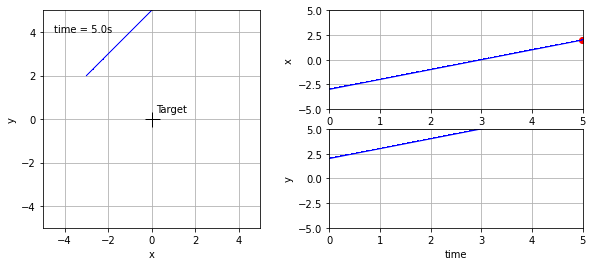

In [4]:
no_controller = {
    'init_state': np.array([-3.0, 1.0, 2.0, 1.0]),
    'Kx': np.array([[0.0, 0.0]]),
    'Ky': np.array([[0.0, 0.0]]),
    't_stop': 5,  # how many seconds to simulate
    'dt': 0.02
}
trajectory_no_controller = simple_car(no_controller)
ani_no_controller = plot_simple_car(trajectory_no_controller, no_controller)
HTML(ani_no_controller.to_html5_video())

You can see that the car moves with constant velocity according to its initial valocities in x and y directions.

Now, lets design the acceleration. My suggestion is
\begin{align*}
u_x = -4 p_x -3 v_x,\\
u_y = -4 p_y -3 v_y.
\end{align*}
This controllers try to select the accerlerations in the opposite directions of the current position and velocity; i.e. to bring to zero. Feel free to change the controller gain to other positive values, the initial condition of the car and the simulation time to explore what you like

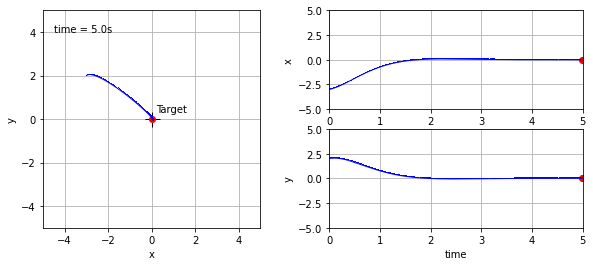

In [5]:
your_controller = {
    'init_state': np.array([-3.0, 1.0, 2.0, 1.0]),
    'Kx': np.array([[-4.0, -3.0]]),
    'Ky': np.array([[-4.0, -3.0]]),
    't_stop': 5,  # how many seconds to simulate
    'dt': 0.02
}
trajectory = simple_car(your_controller)
ani = plot_simple_car(trajectory, your_controller)
HTML(ani.to_html5_video())

The controller we just implmented can be seen as a PD controller
* The P term: We feed in a proportional of the position  which corresponds to the P term 
* The D term: We also feed in a proportional of the position derivative; i.e. a proportional of the velocity which corresponds to the D term.
Now let's see if using a P term or a D term is enough for controlling the system. First we consider a P controller. That is we set all gains related to the velocity equal to zero.

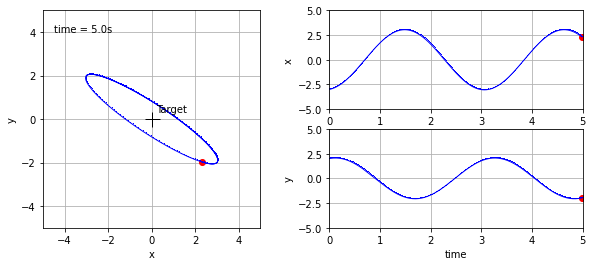

In [6]:
P_controller = {
    'init_state': np.array([-3.0, 1.0, 2.0, 1.0]),
    'Kx': np.array([[-4.0, 0.0]]),
    'Ky': np.array([[-4.0, 0.0]]),
    't_stop': 5,  # how many seconds to simulate
    'dt': 0.02
}

trajectory_P = simple_car(P_controller)
ani_P = plot_simple_car(trajectory_P, P_controller)
HTML(ani_P.to_html5_video())

You can see that it is not possible to control the system by using only the position. The reason is that if the controller is only proportional to the position, when the position is zero or the car is in target, no control is applied to the system. However, the system will not stay at the target position because the velocity is non zero which results the car moves from the target position. This results an oscillatory behavior as you can see in the plot above.

Now, we go ahead and apply only a D controller to the system. That is we set all gains related to the position equal to zero.

In [ ]:
D_controller = {
    'init_state': np.array([-3.0, 1.0, 2.0, 1.0]),
    'Kx': np.array([[0, -3.0]]),
    'Ky': np.array([[0, -3.0]]),
    't_stop': 5,  # how many seconds to simulate
    'dt': 0.02
}

trajectory_D = simple_car(D_controller)
ani_D = plot_simple_car(trajectory_D, D_controller)
HTML(ani_D.to_html5_video())

Again you can see that using a D controller is not enough. Indeed the controller is only proportional to the velocity. That is when the velocity is zero, the control signal is zero and there is no way of correcting the car position. All control effort is directed towards zeroing the velocity only. This shows we need both the position and the velocity in our controller.

What we discussed here is very ad-hoc. We cannot reason about other problems in this way and design the controller. We need to have a mathematical vision towards this problem. 

## State feedback
As we saw, we cannot achieve our control objective by feeding only the output (position in our example). In this section, we define the concept of state feedback. First let's replace the car with a more general linear dynamics
\begin{align*}
\dot{x}=A x +B u
\end{align*}
where $x \in \mathbf{R}^{n}$ represents the state, $u \in \mathbf{R}^{m}$ represents the control input (which we will design), $A$ is called the internal dynamics and $B$ is called the input matrix. We are interested in controlling the above dynamical system to achieve a desired behavior. From now on, we assume that the state variable is available for the controller design. We will cover in another notebook why and when this assumtion is valid.

If no control is applied to the system ($u \equiv 0$), the dynamical system evolves according to internal dynamics $A$
\begin{align*}
\dot{x}= A x
\end{align*}
So the behavior of the system is defined by the matrix $A$ and mostly by its eigenvalues.

However, if we select the controller as $u=K x$ we can affect the internal dynamics change it to something else (within some limits imposed by the dynamics)
\begin{align*}
\dot{x}=& A x+B u\\
=&Ax+BKx=(A+BK)x
\end{align*}
Now, the dynamical systems evolves according to its new internal dynamics $A_{cl}=A+BK$. We can select the matrix $K$ to achieve a desired objective, for example to have stability. To do so it is enough to select $K$ such that the new internal dynamics $A_{cl}=(A+BK)$ has negative eigenvalues

Lets comeback and revisit our probelm. We suggested the following state feedback controller $K=\begin{bmatrix}-4.0,-3.0\end{bmatrix}$ for the simple car. Let's see the eigenvalues of $A+BK$ for the simple car

In [ ]:
A = np.array([[0.0, 1.0], [0.0, 0.0]])
B = np.array([[0.0], [1.0]])
print(np.linalg.eig(A+B@your_controller['Kx'])[0])

You can see that both eigenvalues are negative and as such the simple car dynamics is stable. Now let's see why two other choices of the controller gain do not work. We will undersand it by checking the eigenvalues. First the P case:


In [ ]:
print(np.linalg.eig(A+B@P_controller['Kx'])[0])

You can see that the eigenvalues have zero real parts which result in an oscillatory behavior. Now, we check the D case:

In [ ]:
print(np.linalg.eig(A+B@D_controller['Kx'])[0])

While one of the eigenvalues is negative (stable) the other one is zero and again the system is not internally stable.